# Test segmentation using single dataset and label (OVERFITTING)

## Objective

This is the first test of concept of segmentation of the optic chiasm using Deep Learning (DL). The learning data will consist of:
- T1-weighted (T1w) MRI data of brain of control participant
- Manually created mask of optic chiasm (created on the input T1w image)

The DL network used for the segmentation will be based on kernel for Brain MRI Segmentation Challenge: https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation , which in turn resembles the model architecture presented in the origin UNet paper: https://arxiv.org/pdf/1505.04597.pdf

## Exploratory analysis of the input data

Let's import the libraries we're going to use:

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
import nibabel as nib
from collections import OrderedDict

Using `nibabel` we will load the data - T1w image and corresponding mask of the optic chiasm:

In [2]:
volume = nib.load('../Data/t1.nii.gz')
mask = nib.load('../Data/mask.nii.gz')

Data loaded, let's check the headers of the loaded images

In [3]:
print(volume.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 181 217 181   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FreeSurfer Dec  2 2008'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -90.0
qoffset_y       : -126.0
qoffset_z       : -72.0
srow_x          : [  1.  

In [4]:
print(mask.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b'track-weighted ima'
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 161 211 151   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'MRtrix version: 3.0_RC3_latest-82-g5f55f663'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -80.0
qoffset_y       : -120.0
qoffset_

Those two images are not in the same space - they do differ in dimensions, as well as transformation (which, in Mrtrix, is defined as transformation between image's coordinates in mm and real scanner's coordinates in mm). The voxel size is however identical, which indicates that in order to align those two images simple translation will suffice.
Before we get to this, let's take a look at the data:

In [5]:
volume_image = volume.get_fdata()
mask_image = mask.get_fdata()

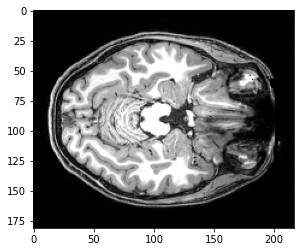

In [6]:
plt.imshow(volume_image[:,:,57], cmap='gray')

This looks fine, the small white-ish structure located at (x=130,y=90) is our target stucture - optic chiasm

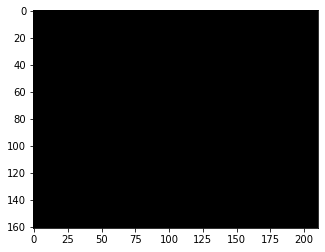

In [7]:
plt.imshow(mask_image[:,:,57], cmap='gray')

But here is a problem - while the part of optic chiasm mask should be visible, it's actually not. The reason for this is misalignment of those 2 images - slices with the same indices are actually not the same slices. In order to correct for this let's create a helper function - it will take both T1w and mask images as input and it will move the mask to the space of the T1w image:

In [8]:
def adjust_mask(target_image, mask_image):
    
    # Create empty mask with dimensions of our target image
    output_image = np.zeros(target_image.get_fdata().shape)
    
    # Calculate difference in offsets, which defines our transition vectors along x-, y- and z-axis
    x_shift = int(mask.header['qoffset_x'] - volume.header['qoffset_x'])
    y_shift = int(mask.header['qoffset_y'] - volume.header['qoffset_y'])
    z_shift = int(mask.header['qoffset_z'] - volume.header['qoffset_z'])
    
    # Extract dimensions of mask
    x_length = mask_image.get_fdata().shape[0]
    y_length = mask_image.get_fdata().shape[1]
    z_length = mask_image.get_fdata().shape[2]
        
    output_image[x_shift:x_shift+x_length,y_shift:y_shift+y_length,z_shift:z_shift+z_length] += mask_image.get_fdata()
    
    return output_image

In [9]:
adjusted_mask = adjust_mask(volume, mask)

Let's now overlay aligned optic chiasm mask (white) on top of target T1w image (gray)

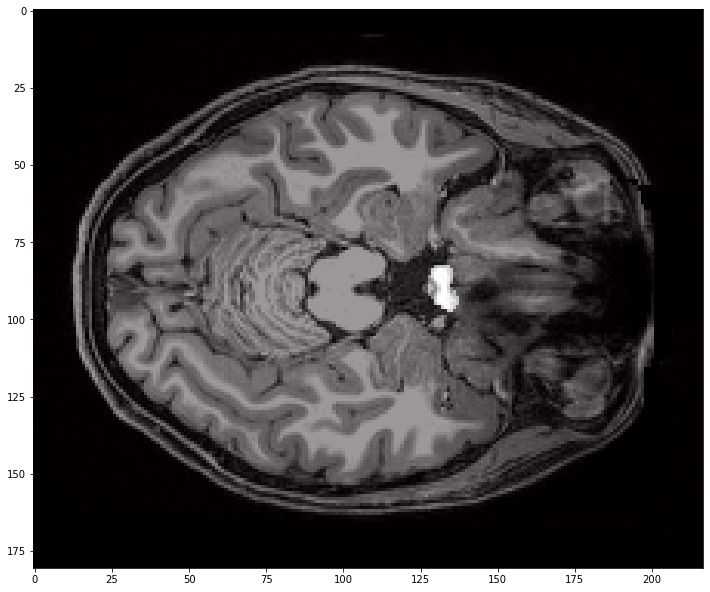

In [10]:
plt.figure(figsize = (12,12))
plt.imshow(volume_image[:,:,56], cmap='gray')
plt.imshow(adjusted_mask[:,:,56], alpha=0.4, cmap='hot')

#plt.imshow(volume_image[:,:,56]*0.01 + adjusted_mask[:,:,56]*1000, cmap='gray')

Excellent, now we can see that the highlighted structure marks the optic chiasm. 

Now let's visalize all slices containing optic chiasm - as of now, due to limited methods, the desired slices will be selected manually.

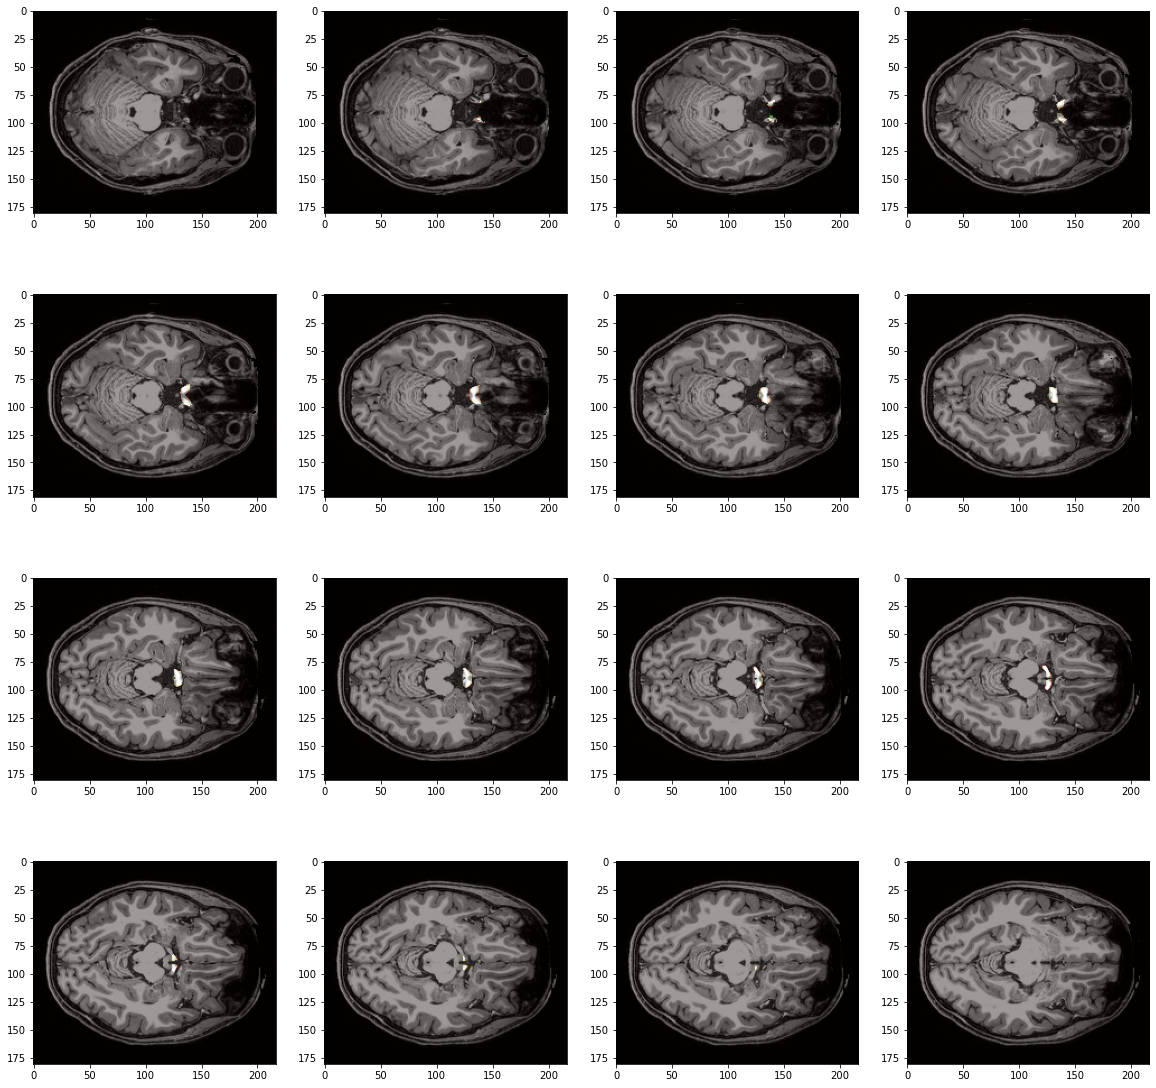

In [11]:
fig = plt.figure(figsize=(20,20))
for i in range(16):
    fig.add_subplot(4,4,i+1)
    plt.imshow(volume_image[:,:,50+i], cmap='gray')
    plt.imshow(adjusted_mask[:,:,50+i], alpha=0.4, cmap='hot')
    

We can notice, that our object of interest is much smaller than the whole-brain volume. For now we will proceed with the whole-brain image, but in the second part of this notebook we will repeat all steps using the cropped image contating chiasm only. This will grant us insight into differences in the required computation time, which will be of importance when designing the ultimate pipeline.

Before we will implement neural network, let's just check the values stored in our T1w and mask images:

In [12]:
print('Minmal pixel value in T1w is equal {}, maximal is equal {}'.format(np.min(volume_image), np.max(volume_image)))

Minmal pixel value in T1w is equal 0.0, maximal is equal 32767.0


Before we will feed the image into network, we need to normalize it - as of now we will do it manually, later on we will have a separate function handling preprocessing of the input images.

In [13]:
volume_image_norm = volume_image/np.max(volume_image)

In [14]:
print(np.max(volume_image_norm))

1.0


Now values stored in T1w image data are looking fine. The last step would be checking the mask - in there we expect only two values - 0s and 1s.

In [15]:
np.unique(adjusted_mask)

array([0., 1.])

Last, but not least - our masks have dimensions 161x211x151 (in voxels). As we're working here with proof of concept it makes sense to crop those images. This will give us 2 benefits:
- reduced time of computations
- avoided issues with dimensions of image while being processed in the subsequent layers of our Convolutional NN

In [16]:
print(volume_image_norm.shape)
print(adjusted_mask.shape)

(181, 217, 181)
(181, 217, 181)


In [17]:
input_t1w = volume_image_norm[30:30+128,45:45+128,30:30+128]
input_mask = adjusted_mask[30:30+128,45:45+128,30:30+128]

print(input_t1w.shape)
print(input_mask.shape)

(128, 128, 128)
(128, 128, 128)


In [18]:
np.unique(input_mask)

array([0., 1.])

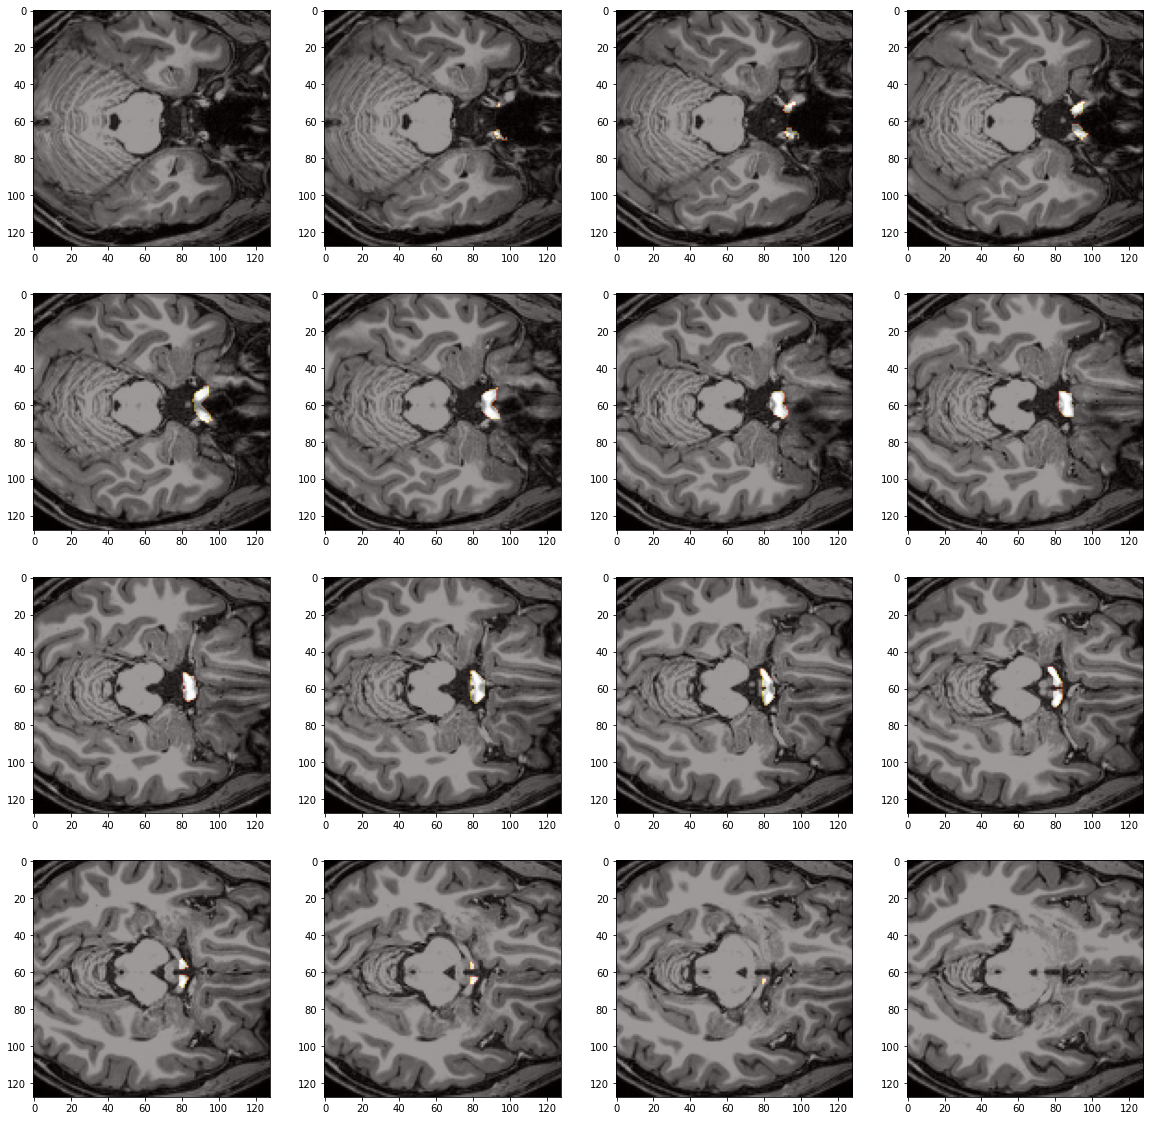

In [19]:
fig = plt.figure(figsize=(20,20))
for i in range(16):
    fig.add_subplot(4,4,i+1)
    plt.imshow(input_t1w[:,:,20+i], cmap='gray')
    plt.imshow(input_mask[:,:,20+i], alpha=0.4, cmap='hot')
    

This looks fine. With this we can finish the preprocessing and data exploration step and move on to implementation of the neural network.

## Implementation of the Neural Network

At first, let's make sure than our code will run on GPU instead of CPU, as this will significantly accelerate the process:

In [20]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
device

device(type='cuda')

That's great, now we can move on to our neural network, which will be designed using following schema:

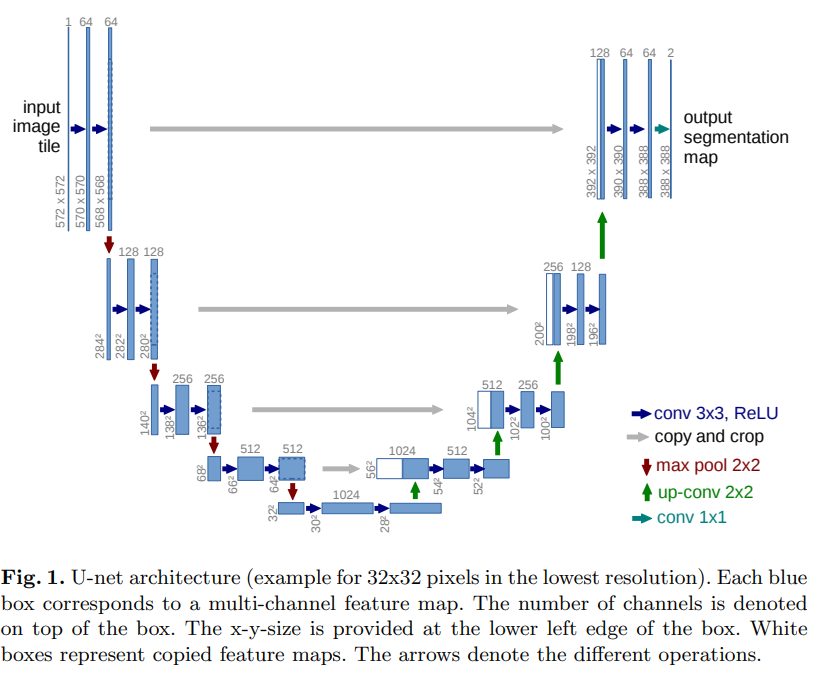

In [21]:
class UNet(nn.Module):
    
    def __init__(self, in_channels=1, out_channels=1, init_features=16):
        super(UNet, self).__init__()
        
        # Parameter determining depth of layers when going down the network
        features = init_features
        
        # Encoding layers
        self.encoder1 = self.unet_block(in_channels, features, "enc1")
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.encoder2 = self.unet_block(features, features*2, name='enc2')
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.encoder3 = self.unet_block(features*2, features*4, name='enc3')
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.encoder4 = self.unet_block(features*4, features*8, name='enc4')
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        
        # Bottleneck layer
        self.bottleneck = self.unet_block(features*8, features*8*2, name='bottleneck')
        
        # Decoding layers (where merge with prevois encoding layers occurs)
        self.upconv4 = nn.ConvTranspose3d(features*8*2, features*8, kernel_size=2, stride=2)        
        self.decoder4 = self.unet_block(features*8*2, features*8, name='dec4')
        
        self.upconv3 = nn.ConvTranspose3d(features*4*2, features*4, kernel_size=2, stride=2)
        self.decoder3 = self.unet_block(features*4*2, features*4, name='dec3')
        
        self.upconv2 = nn.ConvTranspose3d(features*2*2, features*2, kernel_size=2, stride=2)
        self.decoder2 = self.unet_block(features*2*2, features*2, name='dec2')
        
        self.upconv1 = nn.ConvTranspose3d(features*2, features, kernel_size=2, stride=2)
        self.decoder1 = self.unet_block(features*2, features, name='dec1')
        
        # Final convolution - output equals number of output channels
        self.conv = nn.Conv3d(features, out_channels, kernel_size=1)
        self.softmax = nn.Softmax(dim=1)   
        
    def forward(self,x):
        
        # Encoding
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))  
        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        # Upconvolving, concatenating data from respective encoding phase and executing UNet block
        dec4 = self.upconv4(bottleneck)
           
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        out_conv = self.conv(dec1)
        
        return self.softmax(out_conv)
    
    def unet_block(self, in_channels, features, name):
        
        return nn.Sequential(OrderedDict([(name+'conv1',nn.Conv3d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1, bias=False)),
                             (name+'bnorm1', nn.BatchNorm3d(num_features=features)),
                             (name+'relu1', nn.ReLU(inplace=True)),
                             (name+'conv2', nn.Conv3d(in_channels=features, out_channels=features, kernel_size=3, padding=1, bias=False)),
                             (name+'bnorm2', nn.BatchNorm3d(num_features=features)),
                             (name+'relu2', nn.ReLU(inplace=True))])
                            )

Let's take a look at the summary of the created network:

In [22]:
unet = UNet(1,2)
#print(unet)

This is it! In order to have a full picture, let's check the number of parameters we will be adjusting:

In [23]:
sum(p.numel() for p in unet.parameters() if p.requires_grad)

5646402

Now that the network model is defined, let's initialize it with required number of input (1 - T1w image) and output (2 - predicted mask and background) channels. Once it's initalized, we move the network to target devica (CUDA in this case).
Secondly, we define the loss function - for the task of voxel-wise segmentation Cross Entropy appears to be reasonable starting point. Finally, we define the optimizer function, where we will stick to widely used and appreciated Adam optimizer.

In [24]:
# We initialize our network - it takes 1-channel input (image) and returns 2-channels (mask and background)
unet = UNet(1,2)

# And we move it to our target device
unet.to(device)

# Now definition of loss - for now let's stick with Cross Entropy loss, which should be sufficient for voxel-wise
# comparison. Optionally later on we can try dice or other metrics
criterion = nn.CrossEntropyLoss()

# As far as optimizer in concerned, let's stick to good old Adam
optimizer = torch.optim.Adam(params=unet.parameters(), lr=0.001)

Since everything is set up, let's move on to training loop!

In [25]:
%%time

# Set network to training mode
unet.train()

epochs = 100

vol = torch.from_numpy(input_t1w.astype(np.single)).unsqueeze(0).unsqueeze(0).to(device)
lbl = torch.from_numpy(input_mask).unsqueeze(0).long().to(device)

for epoch in range(1,epochs):
    
    optimizer.zero_grad()
    
    pred = unet(vol)
    loss = criterion(pred,lbl)
    loss.backward()
    optimizer.step()
    
    print(f"Epoch: {epoch}, training loss: {loss}") 

Epoch: 1, training loss: 0.6988547444343567
Epoch: 2, training loss: 0.6946359872817993
Epoch: 3, training loss: 0.6815781593322754
Epoch: 4, training loss: 0.6660150289535522
Epoch: 5, training loss: 0.6514793038368225
Epoch: 6, training loss: 0.639378011226654
Epoch: 7, training loss: 0.6279879808425903
Epoch: 8, training loss: 0.6150235533714294
Epoch: 9, training loss: 0.6122528314590454
Epoch: 10, training loss: 0.602099597454071
Epoch: 11, training loss: 0.596027135848999
Epoch: 12, training loss: 0.5954337120056152
Epoch: 13, training loss: 0.5862512588500977
Epoch: 14, training loss: 0.5827358961105347
Epoch: 15, training loss: 0.5794317722320557
Epoch: 16, training loss: 0.5759380459785461
Epoch: 17, training loss: 0.5728291273117065
Epoch: 18, training loss: 0.5690656900405884
Epoch: 19, training loss: 0.5657955408096313
Epoch: 20, training loss: 0.5628165602684021
Epoch: 21, training loss: 0.5600465536117554
Epoch: 22, training loss: 0.5570589303970337
Epoch: 23, training lo

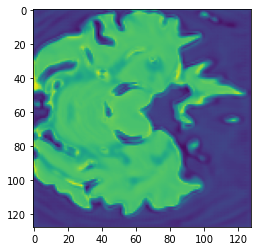

In [26]:
plt.imshow(pred.cpu().detach()[0,1][:,:,26])

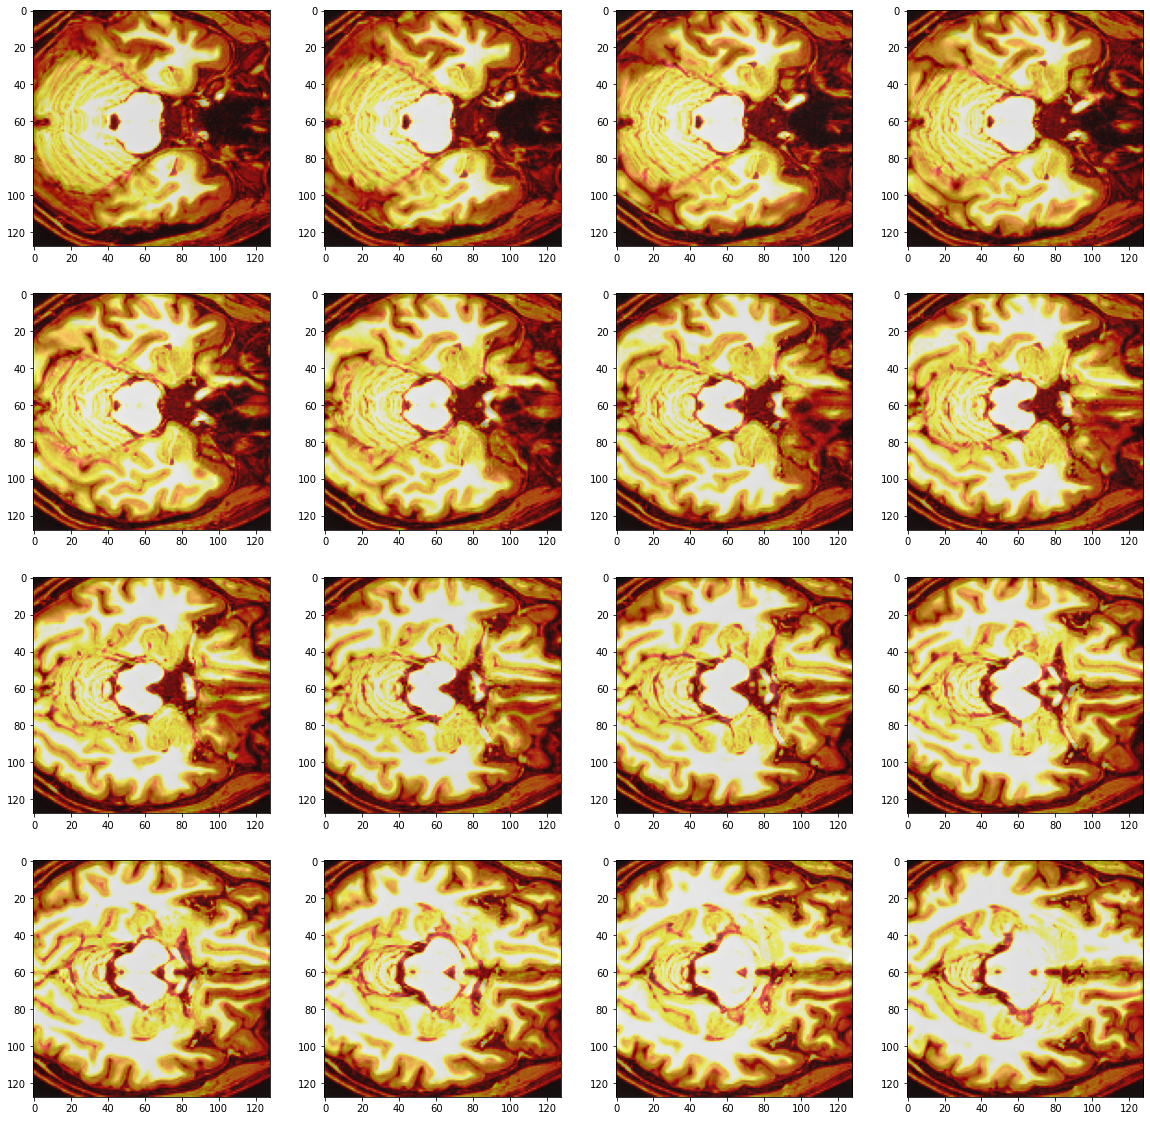

In [30]:
fig = plt.figure(figsize=(20,20))
for i in range(16):
    fig.add_subplot(4,4,i+1)
    plt.imshow(input_t1w[:,:,20+i], cmap='hot')
    plt.imshow(pred.cpu().detach()[0,1][:,:,20+i], alpha=0.4, cmap='gray')